In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(42)

### Функция для работы с .jpg - определение черных и белых пикселей в rgb пространстве

In [4]:
def is_black(rgb):
  return rgb[0] == rgb[1] == rgb[2] == 0

def is_white(rgb):
  return rgb[0] == rgb[1] == rgb[2] == 255

### Исходное изображение

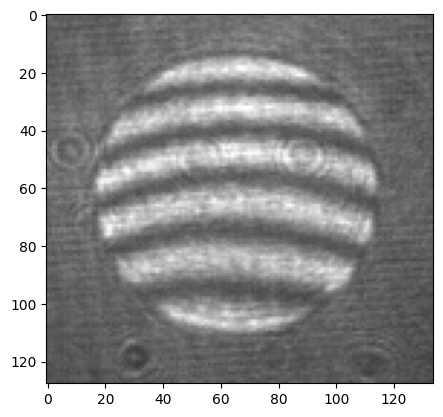

In [5]:
im = plt.imread('int.jpg')

plt.imshow(im)
plt.show()

In [6]:

# создание бинарного изображения по некоторому уровню "яркости" пикселей (работает только с .bmp)
# for bmp
# level = 150
# binary = im > level
# plt.imshow(binary)
# plt.show()

### Функция для создания бинарного изображения по уровню factor = сумма значений компонент rgb

In [7]:
def contrast (im, factor):
    #for jpg
    im2 = np.copy(im)

    for y in range(len(im2)):
        for x in range(len(im2[0])):
            current = im2[y][x]
            current_sum = sum(current)
            im2[y][x] = [0, 0, 0] if current_sum < factor else [255, 255, 255]
    return im2

### Создание бинарного изображения для определения размеров окружности, описанной вокруг интерферограммы

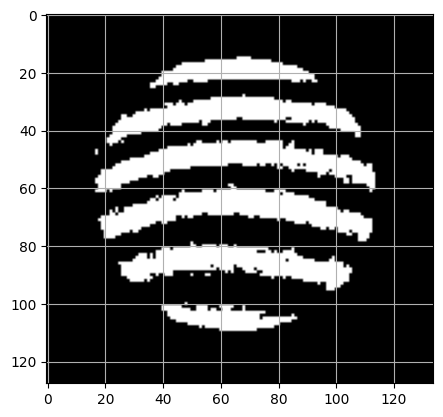

In [8]:
im2 = contrast(im, 460) #значение factor берется большим, чтобы гарантированно исключить засветы вокруг интерферограммы
plt.imshow(im2)
plt.grid()
plt.show()

### Определение центра и радиуса интерферограммы

In [9]:
top = left = (len(im2[0]), len(im2)) 
right = bottom = (0, 0)
for y in range(len(im2)):
    for x in range(len(im2[0])):
        current = im2[y][x]
        current_sum = sum(current)
        if current_sum > 0:
            if y < top[1]: top = (x, y)
            if y > bottom[1]: bottom = (x, y)
            if x < left[0]: left = (x, y)
            if x > right[0]: right = (x, y)

#print(top, left, right, bottom, sep=' ')
center_x = (left[0]+right[0])//2
center_y = (top[1]+bottom[1])//2
c_int = (center_y, center_x)
R_int = max(abs(right[0] - center_x), abs(bottom[1] - center_y))
print(c_int, R_int)

(62, 65) 48


### Показать вычисленный центр интерферограммы на рисунке

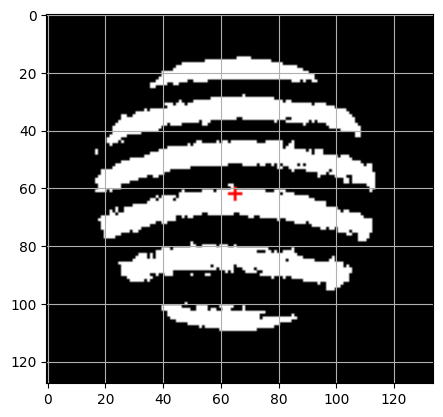

In [10]:
#center mark
color = [255, 0, 0]
im3 = np.copy(im2)
im3[center_y][center_x] = color
im3[center_y + 1][center_x] = color
im3[center_y - 1][center_x] = color
im3[center_y][center_x + 1] = color
im3[center_y][center_x - 1] = color
im3[center_y + 2][center_x] = color
im3[center_y - 2][center_x] = color
im3[center_y][center_x + 2] = color
im3[center_y][center_x - 2] = color
plt.imshow(im3)
plt.grid()
plt.show()

### Построение окружности, описывающей интерферограмму

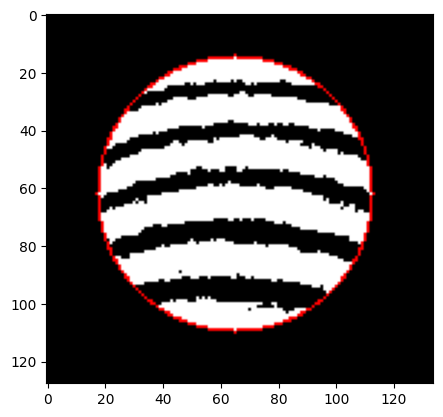

In [11]:
im4 = contrast(im, 380) #значение factor берется меньшим, чтобы не потерять информацию о форме интерференционных полос
im4_1 = np.copy(im4)
# plt.imshow(im4)
# plt.show()

for y in range(len(im4)):
    for x in range(len(im4[0])):
        dist = math.dist(c_int, (y, x))
        if dist > R_int:                        #убирает "мусор" вне окружности
            im4[y][x] = [0, 0, 0]
            im4_1[y][x] = [0, 0, 0]
        elif (1 > R_int - dist >= 0):           #построение окружности на рисунке
            im4[y][x] = [255, 0, 0]

plt.imshow(im4)
plt.show()

### Определение верхних точек интерференционных полос для аппроксимации

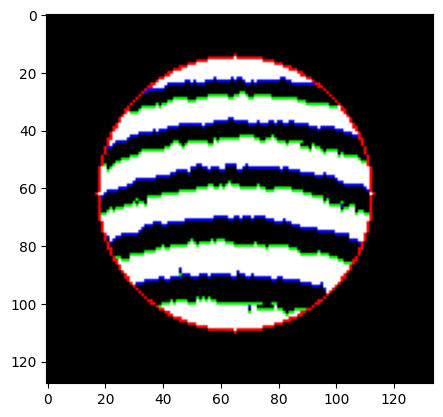

In [12]:
im5 = np.copy(im4)

curves_points_up = []
curves_points_bottom = []

#если выбранная точка белая, а точка над ней черная - запомнить и отметить
for y in range(len(im5)):
  for x in range(len(im5[0])):
    if is_black(im5[y - 1][x]) and is_white(im5[y][x]):
      im5[y][x] = [0, 255, 0]
      curves_points_up.append([x, y])

for y in range(len(im5) - 1):
  for x in range(len(im5[0])):    
    if is_black(im5[y + 1][x]) and is_white(im5[y][x]):
      im5[y][x] = [0, 0, 255]
      curves_points_bottom.append([x, y])

plt.imshow(im5)
plt.show()

### Получение информации о кривых интерферограммы

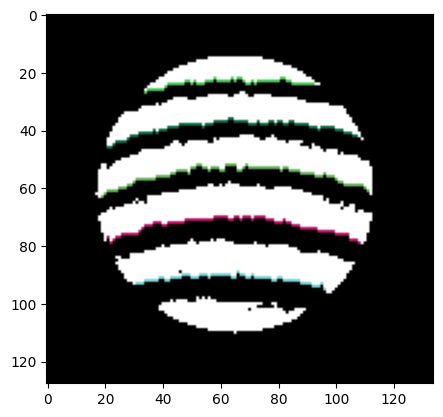

In [13]:
x_sorted_curves_points_bottom = sorted(curves_points_bottom, key=lambda p: p[0])
# print(x_sorted_curves_points_bottom)

# берется самая левая белая точка и ищется ближайшая к ней белая точка до тех пор, пока точек не останется
# когда вычисление кривой закончено, точки этой кривой удаляются из общего массива точек
def get_curve():
  fp = x_sorted_curves_points_bottom.pop(0)

  curve = [fp]

  if len(x_sorted_curves_points_bottom) == 0:
    return curve

  p = min(x_sorted_curves_points_bottom, key=lambda point: math.dist(point, fp))
  dist = math.dist(p, fp)

  #
  # настроить макисмальное растояние
  #
  while dist < 15:
    curve.append(p)
    x_sorted_curves_points_bottom.remove(p)

    x_closest = list(filter(lambda point: point[0] - curve[-1][0] == 1, x_sorted_curves_points_bottom))

    if len(x_closest) == 0:
      break

    p = min(x_closest, key=lambda point: math.dist(point, curve[-1]))
    dist = math.dist(p, curve[-1])
  
  return curve

im6 = np.copy(im4_1)

curves_bottom = [] # массив с координатами кривых

# убрать слишком короткие кривые, которые не должны участвовать в аппроксиммации
while len(x_sorted_curves_points_bottom) > 0:
  curve = get_curve()

  #
  # настроить минимальную длину
  #
  if len(curve) < 10:
    continue

  curves_bottom.append(curve)

  color = np.random.choice(range(0, 256), 3)
  for p in curve:
    im6[p[1]][p[0]] = color
    # im6[p[1] + 1][p[0]] = color
    # im6[p[1] - 1][p[0]] = color

plt.imshow(im6)
plt.show()

curves_bottom_y_sorted = sorted(curves_bottom, key = lambda p: p[len(p)//2][1])
# print(curves_bottom_y_sorted)

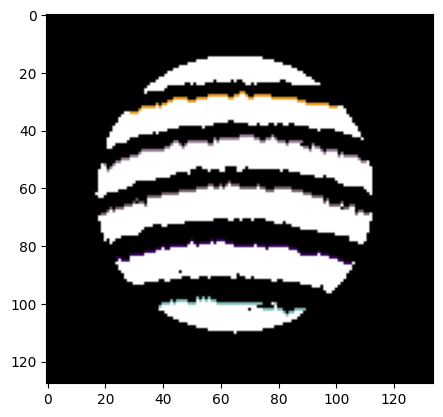

In [14]:
x_sorted_curves_points_up = sorted(curves_points_up, key=lambda p: p[0])
# print(x_sorted_curves_points_bottom)

# берется самая левая белая точка и ищется ближайшая к ней белая точка до тех пор, пока точек не останется
# когда вычисление кривой закончено, точки этой кривой удаляются из общего массива точек
def get_curve():
  fp = x_sorted_curves_points_up.pop(0)

  curve = [fp]

  if len(x_sorted_curves_points_up) == 0:
    return curve

  p = min(x_sorted_curves_points_up, key=lambda point: math.dist(point, fp))
  dist = math.dist(p, fp)

  #
  # настроить макисмальное растояние
  #
  while dist < 15:
    curve.append(p)
    x_sorted_curves_points_up.remove(p)

    x_closest = list(filter(lambda point: point[0] - curve[-1][0] == 1, x_sorted_curves_points_up))

    if len(x_closest) == 0:
      break

    p = min(x_closest, key=lambda point: math.dist(point, curve[-1]))
    dist = math.dist(p, curve[-1])
  
  return curve

im7 = np.copy(im4_1)

curves_up = [] # массив с координатами кривых

# убрать слишком короткие кривые, которые не должны участвовать в аппроксиммации
while len(x_sorted_curves_points_up) > 0:
  curve = get_curve()

  #
  # настроить минимальную длину
  #
  if len(curve) < 10:
    continue

  curves_up.append(curve)

  color = np.random.choice(range(0, 256), 3)
  for p in curve:
    im7[p[1]][p[0]] = color
    # im6[p[1] + 1][p[0]] = color
    # im6[p[1] - 1][p[0]] = color

plt.imshow(im7)
plt.show()

curves_up_y_sorted = sorted(curves_up, key = lambda p: p[len(p)//2][1])
# print(curves_up_y_sorted)

59


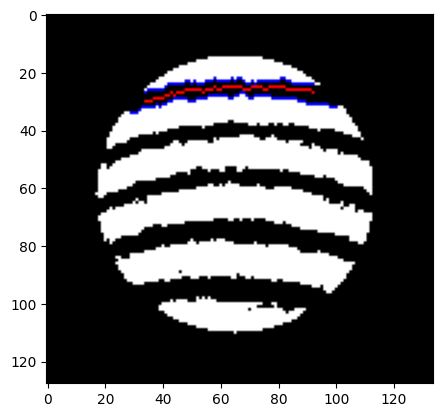

In [15]:
im8 = np.copy(im4_1)

curves = []

min_len_local = min(len(curves_up_y_sorted[0]), len(curves_bottom_y_sorted[0]))
print(min_len_local)

for i in range(len(curves_up_y_sorted[0])):
    im8[curves_up_y_sorted[0][i][1]][curves_up_y_sorted[0][i][0]] = [0, 0, 255]

for i in range(len(curves_bottom_y_sorted[0])):
    im8[curves_bottom_y_sorted[0][i][1]][curves_bottom_y_sorted[0][i][0]] = [0, 0, 255]

for i in range(min_len_local):
    im8[int((curves_bottom_y_sorted[0][i][1] + curves_up_y_sorted[0][i][1]) / 2)][curves_bottom_y_sorted[0][i][0]] = [255, 0, 0]
    curves.append([int((curves_bottom_y_sorted[0][i][1]+curves_up_y_sorted[0][i][1]) / 2), curves_bottom_y_sorted[0][i][0]])

plt.imshow(im8)
plt.show()
# print(curves)

### Аппроксимация кривых интерферограммы с помощью МНК

In [16]:
'''
def poly(curve):
  global polynom
  x = list(map(lambda p: p[1], curve))
  y = list(map(lambda p: p[0], curve))

  legend = []
  for d in range(2, 5):
    fp, residuals, rank, sv, rcond = np.polyfit(x, y, d, full=True) # d - степень полинома

    f = np.poly1d(fp)
    if d == 4: 
      polynom = f

    print(f)
    plt.plot(x, f(x), linewidth=2)
    legend.append("d=%i" % f.order)

  plt.imshow(im)
  plt.legend(legend, loc="upper left")
  plt.show()

# for i in range(len(curves)):
  # poly(curves[i])
poly(curves)
'''

'\ndef poly(curve):\n  global polynom\n  x = list(map(lambda p: p[1], curve))\n  y = list(map(lambda p: p[0], curve))\n\n  legend = []\n  for d in range(2, 5):\n    fp, residuals, rank, sv, rcond = np.polyfit(x, y, d, full=True) # d - степень полинома\n\n    f = np.poly1d(fp)\n    if d == 4: \n      polynom = f\n\n    print(f)\n    plt.plot(x, f(x), linewidth=2)\n    legend.append("d=%i" % f.order)\n\n  plt.imshow(im)\n  plt.legend(legend, loc="upper left")\n  plt.show()\n\n# for i in range(len(curves)):\n  # poly(curves[i])\npoly(curves)\n'

### Аппроксимация кривых интерферограммы с помощью уравнения окружности

In [36]:
from scipy.optimize import curve_fit

# Функция, описывающая уравнение верхнюю половину окружности
def circle_func(x, a, b, r):
  return np.sqrt(r**2 - (x - a)**2) + b

def line_func(x, k, b):
  return x*k + b

def sqrt_func(x, a, b):
  return (x + a)**(0.5) + b

def exp_func(x, a, b):
  return np.exp(x + a) + b

def fit_circle(curve, curve_func):
  # Заданные точки
  x = list(map(lambda p: p[1], curve))
  y = list(map(lambda p: p[0], curve))

  # Используем метод curve_fit для аппроксимации точек функцией circle_func
  # params, cov = curve_fit(curve_func, x, y, method='trf', bounds=([-x[0], -math.inf], [math.inf, math.inf])) # for sqrt
  params, cov = curve_fit(curve_func, x, y, method='trf', bounds=([0, 0, 0], [2, math.inf, math.inf])) # for circle

  print(params)

  y_computed = [curve_func(xi, *params) for xi in x]
  print(x, y_computed)

  fig = plt.figure()
  ax = fig.add_subplot()
  plt.scatter(x, y)
  plt.plot(x, y_computed, color='#333')
  ax.set_aspect('equal', adjustable='box')
  plt.show()

circle_curve = [[73.482, 33.2], [90, 60], [78, 84], [82.361, 40], [87.037, 73]]
sqrt_curve = [[1, -6], [3, -2], [3.449, 0], [4.464, 6]]
line_curve = [[10, 1], [14, 5], [19, 10], [53, 44]]
exp_curve = [[-9, -12], [-8, -1], [-6.282, 0], [0, 1.197], [3.747, 1.545]]

# fit_circle(sqrt_curve, sqrt_func)
fit_circle(circle_curve, circle_func)

C:\Users\alex\AppData\Local\Temp\ipykernel_3712\1098123784.py:5: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(r**2 - (x - a)**2) + b


ValueError: Residuals are not finite in the initial point.

```
(x - xc)^2 + (y - yc)^2 = r^2

(y - yc)^2 = r^2 - (x - xc)^2

y - yc = sqrt(r^2 - (x - xc)^2)

y = sqrt(r^2 - (x - xc)^2) + yc
```